In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-learn

In [ ]:
!pip install evaluate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f06f4a1d59c47123d38284fd7e6a600997bd1decd860b63de488b529f0b06eba
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


Loading and preparing train data...
Loading and preparing dev and test data...

Combined dev and test sets into a single final test set of 29517 sentences.

Processed 126169 training sentences.

Vectorizing features...
Starting model training with Naive Bayes...

--- Detailed Evaluation on Combined Test Set (Naive Bayes) ---

Final Test Set Classification Report:
Entity                Precision     Recall   F1-Score    Support
-----------------------------------------------------------------
EMOJI_CAMO               0.9513     0.9601     0.9557       4113
EMOJI_CHAR_CAMO          0.6379     0.7056     0.6700       6189
INV_CAMO                 0.9672     0.8662     0.9139        680
LEETSPEAK                0.8593     0.9425     0.8990       5457
MIX_CAMO                 0.1161     0.1630     0.1356       6539
PUNCT_CAMO               0.2703     0.6324     0.3787       6539
-----------------------------------------------------------------
Accuracy                                       

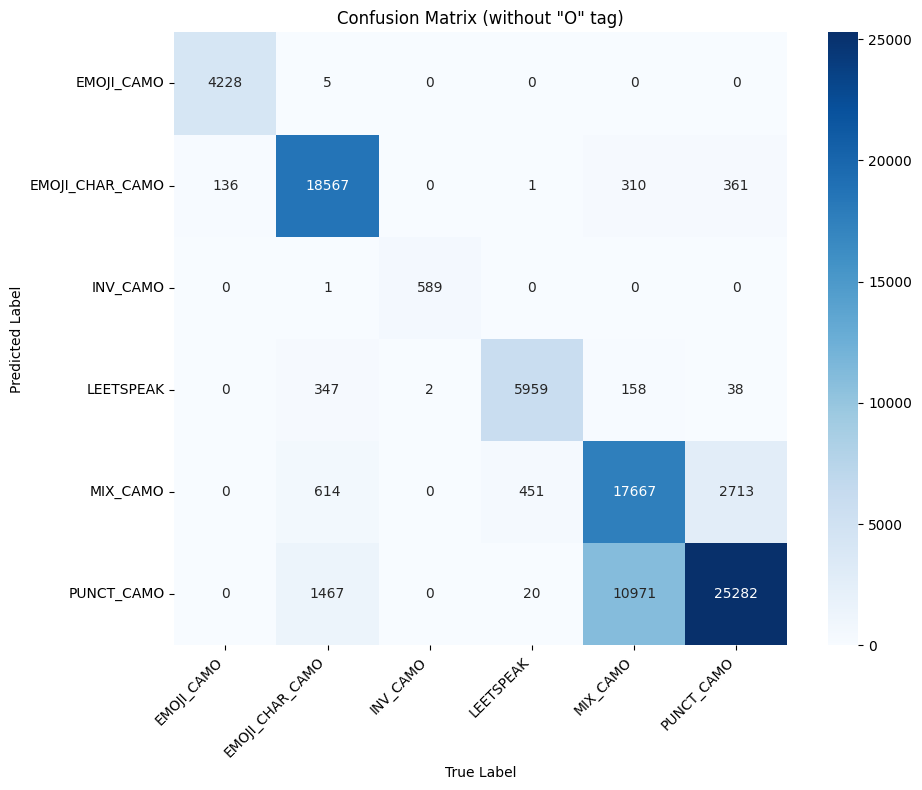

Metrics bar chart saved to: /content/drive/My Drive/Vidath/traditional_model/NaiveBayes/nb_final_metrics_barchart.png


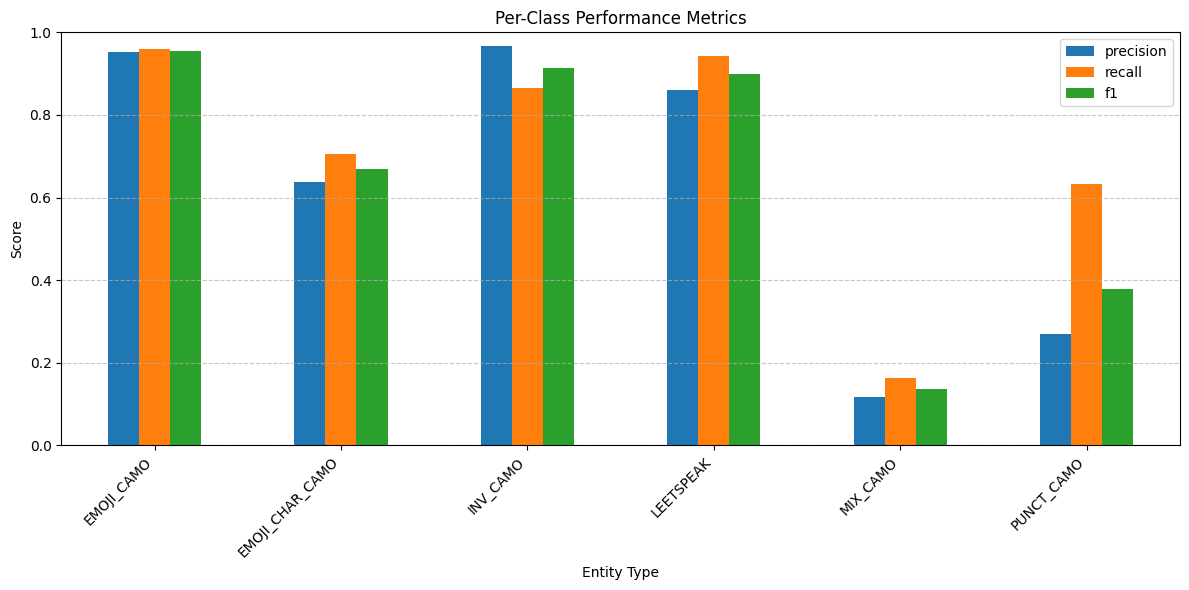


Model saved to /content/drive/My Drive/Vidath/traditional_model/NaiveBayes/nb-ner-model-emoji.joblib
Vectorizer saved to /content/drive/My Drive/Vidath/traditional_model/NaiveBayes/nb-vectorizer-emoji.joblib


In [ ]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import re
# --- MODIFICATION: Import Naive Bayes instead of SVM ---
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from evaluate import load
import joblib
import os

### --- Imports for visualization --- ###
import matplotlib.pyplot as plt
import seaborn as sns

# Need seqeval for metric computation
try:
    from evaluate import load
    load("seqeval")
except ImportError:
    print("Installing seqeval and evaluate...")
    import subprocess
    subprocess.check_call(["pip", "install", "evaluate", "seqeval"])
    from evaluate import load

# 2. Labels and Feature Engineering (No changes needed)
BASE_LABELS = ["LEETSPEAK", "PUNCT_CAMO", "INV_CAMO", "MIX_CAMO", "EMOJI_CAMO", "EMOJI_CHAR_CAMO"]
LABEL_LIST = ["O"] + [f"B-{label}" for label in BASE_LABELS] + [f"I-{label}" for label in BASE_LABELS]

def is_emoji(s):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return re.match(emoji_pattern, s) is not None

def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0, 'word.lower()': word.lower(), 'word[-3:]': word[-3:], 'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(), 'word.istitle()': word.istitle(), 'word.isdigit()': word.isdigit(),
        'word.has_digit': any(char.isdigit() for char in word),
        'word.has_punct': any(not char.isalnum() for char in word),
        'word.is_emoji': is_emoji(word), 'word.has_emoji': any(is_emoji(char) for char in word),
    }
    if i > 0:
        prev_word = sent[i-1]
        features.update({
            '-1:word.lower()': prev_word.lower(), '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(), '-1:word.is_emoji': is_emoji(prev_word),
        })
    else: features['BOS'] = True
    if i < len(sent)-1:
        next_word = sent[i+1]
        features.update({
            '+1:word.lower()': next_word.lower(), '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(), '+1:word.is_emoji': is_emoji(next_word),
        })
    else: features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(labels):
    return labels

def load_and_prepare_data_svm(file_path):
    df = pd.read_csv(file_path, encoding='utf-8')
    grouped = df.groupby('Text').apply(lambda x: x.to_dict('records'), include_groups=False).reset_index(name='entities')
    sentences = []
    for _, row in grouped.iterrows():
        text = str(row['Text']) if pd.notna(row['Text']) else ""
        entities = row['entities']
        tokens_with_spans = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\w+|[^\s\w]', text)]
        tokens = [t[0] for t in tokens_with_spans]
        labels = ['O'] * len(tokens)
        for entity in entities:
            ent_start, ent_end, ent_label = entity['Start'], entity['End'], entity['Label']
            if f"B-{ent_label}" not in LABEL_LIST: continue
            in_entity = False
            for i, (token, tok_start, tok_end) in enumerate(tokens_with_spans):
                if max(tok_start, ent_start) < min(tok_end, ent_end):
                    labels[i] = f"B-{ent_label}" if not in_entity else f"I-{ent_label}"
                    in_entity = True
                else: in_entity = False
        sentences.append((tokens, labels))
    return sentences

# 3. Data Loading and Preparation (No changes needed)
print("Loading and preparing train data...")
train_sents = load_and_prepare_data_svm("/content/drive/My Drive/Vidath/Dataset/augmented_train_all_combo_emoji.csv")
print("Loading and preparing dev and test data...")
dev_sents = load_and_prepare_data_svm("/content/drive/My Drive/Vidath/Dataset/augmented_dev_all_combo_emoji.csv")
test_sents = load_and_prepare_data_svm("/content/drive/My Drive/Vidath/Dataset/augmented_test_all_combo_emoji.csv")

combined_test_sents = dev_sents + test_sents
print(f"\nCombined dev and test sets into a single final test set of {len(combined_test_sents)} sentences.")

def prepare_data_for_sklearn(sents):
    X = [sent2features(s[0]) for s in sents]
    y = [sent2labels(s[1]) for s in sents]
    X_flat = [item for sublist in X for item in sublist]
    y_flat = [item for sublist in y for item in sublist]
    return X, y, X_flat, y_flat

_, _, X_train_flat, y_train_flat = prepare_data_for_sklearn(train_sents)
X_test, y_test, _, _ = prepare_data_for_sklearn(combined_test_sents)

print(f"\nProcessed {len(train_sents)} training sentences.")

# 4. Model Training
print("\nVectorizing features...")
vectorizer = DictVectorizer(sparse=True)
X_train_vec = vectorizer.fit_transform(X_train_flat)

# --- MODIFICATION: Instantiate and train MultinomialNB model ---
print("Starting model training with Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train_flat)

# 5. Evaluation and Reporting Functions (No changes needed in these functions)
def print_classification_report(report_dict):
    print(f"{'Entity':<20} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 65)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):
            name, precision = label, metrics.get('precision', 0)
            recall, support = metrics.get('recall', 0), metrics.get('number', 0)
            f1 = metrics.get('f1', 0)
            print(f"{name:<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10}")
    print("-" * 65)
    precision, recall = report_dict.get('overall_precision', 0), report_dict.get('overall_recall', 0)
    f1, accuracy = report_dict.get('overall_f1', 0), report_dict.get('overall_accuracy', 0)
    print(f"{'Accuracy':<20} {accuracy:>33.4f}")
    print(f"{'Overall (Micro Avg)':<20} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f}\n")

def aggregate_bio_tags(labels):
    return [label[2:] if label not in ['O'] else 'O' for label in labels]

def plot_confusion_matrix(y_true, y_pred, labels, save_path):
    labels_without_o = sorted([l for l in labels if l != 'O'])
    y_true_flat, y_pred_flat = [item for sublist in y_true for item in sublist], [item for sublist in y_pred for item in sublist]
    y_true_agg, y_pred_agg = aggregate_bio_tags(y_true_flat), aggregate_bio_tags(y_pred_flat)
    mat = confusion_matrix(y_true_agg, y_pred_agg, labels=labels_without_o)
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=labels_without_o, yticklabels=labels_without_o, cmap="Blues")
    plt.title('Confusion Matrix (without "O" tag)'); plt.xlabel('True Label'); plt.ylabel('Predicted Label')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Confusion matrix saved to: {save_path}")
    plt.show()

def plot_metrics_barchart(report_dict, save_path):
    class_data = {label: metrics for label, metrics in report_dict.items() if isinstance(metrics, dict)}
    df = pd.DataFrame(class_data).T.reset_index().rename(columns={'index': 'Entity'})
    df.plot(x='Entity', y=['precision', 'recall', 'f1'], kind='bar', figsize=(12, 6))
    plt.title('Per-Class Performance Metrics'); plt.ylabel('Score'); plt.xlabel('Entity Type')
    plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Metrics bar chart saved to: {save_path}")
    plt.show()

metric = load("seqeval")
def evaluate_model(model, vectorizer, X_sents, y_sents_true):
    y_sents_pred = []
    for sent_features in X_sents:
        if not sent_features: y_sents_pred.append([]); continue
        sent_vec = vectorizer.transform(sent_features)
        y_sents_pred.append(list(model.predict(sent_vec)))
    results = metric.compute(predictions=y_sents_pred, references=y_sents_true)
    return results, y_sents_pred

# 6. Final Evaluation
# --- MODIFICATION: Update directory path for Naive Bayes results ---
plots_dir = "/content/drive/My Drive/Vidath/traditional_model/NaiveBayes"
os.makedirs(plots_dir, exist_ok=True)

print("\n--- Detailed Evaluation on Combined Test Set (Naive Bayes) ---")
# --- MODIFICATION: Pass the nb_model to the evaluation function ---
test_report_raw, test_preds = evaluate_model(nb_model, vectorizer, X_test, y_test)

test_report_clean = {}
for key, value in test_report_raw.items():
    if isinstance(value, dict) and 'f1-score' in value:
        new_value = value.copy(); new_value['f1'] = new_value.pop('f1-score'); test_report_clean[key] = new_value
    else: test_report_clean[key] = value

print("\nFinal Test Set Classification Report:")
print_classification_report(test_report_clean)

cm_save_path = os.path.join(plots_dir, "nb_final_confusion_matrix.png")
plot_confusion_matrix(y_test, test_preds, labels=BASE_LABELS, save_path=cm_save_path)

metrics_save_path = os.path.join(plots_dir, "nb_final_metrics_barchart.png")
plot_metrics_barchart(test_report_clean, save_path=metrics_save_path)

# 7. Save Model and Predict
# --- MODIFICATION: Update model and vectorizer paths ---
model_path = "/content/drive/My Drive/Vidath/traditional_model/NaiveBayes/nb-ner-model-emoji.joblib"
vectorizer_path = "/content/drive/My Drive/Vidath/traditional_model/NaiveBayes/nb-vectorizer-emoji.joblib"
joblib.dump(nb_model, model_path)
joblib.dump(vectorizer, vectorizer_path)
print(f"\nModel saved to {model_path}")
print(f"Vectorizer saved to {vectorizer_path}")

# --- MODIFICATION: Renamed prediction function for clarity ---
def predict_ner_nb(text, model, vectorizer):
    tokens_with_spans = [(m.group(0), m.start(), m.end()) for m in re.finditer(r'\w+|[^\s\w]', text)]
    if not tokens_with_spans: return []
    tokens = [t[0] for t in tokens_with_spans]
    features = sent2features(tokens)
    feature_vec = vectorizer.transform(features)
    predicted_labels = model.predict(feature_vec)
    entities = []
    current_entity = None
    for i, label in enumerate(predicted_labels):
        token, start, end = tokens_with_spans[i]
        if label.startswith("B-"):
            if current_entity: entities.append(current_entity)
            current_entity = {"label": label[2:], "start": start, "end": end}
        elif label.startswith("I-") and current_entity and label[2:] == current_entity["label"]:
            current_entity["end"] = end
        else:
            if current_entity: entities.append(current_entity)
            current_entity = None
    if current_entity: entities.append(current_entity)
    for entity in entities: entity["entity"] = text[entity["start"]:entity["end"]]
    return entities